# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Перед нами стоит несколько задач. 

Первая — обучить несколько моделей для предсказаний стоимости автомобиля на основе данных заказчика. Вторая задача — сравнить скорости обучения, скорости предсказаний и точность моделей, выбрать для заказчика лучший вариант.
  
# Цель исследования:

  1) Изучить исходные данные.\
  2) Обработать данные.\
  3) Выполнить подготовку и обучение моделей.\
  4) Выбрать лучшую модель по скорости обучения, предсказания и точности.\
  6) Написание итогового вывода.
  
# Ход исследования:
  
   Данные получим из файла autos.csv. О качестве данных ничего не известно, поэтому необходимо будет тщательно изучить их.
   
   На этапе предобработки данных найдём все пропущенные значения, обработаем их, удалим явные выбросы, избавимся от дубликатов. После этого исследуем зависимости между параметрами, построим необходимые диаграммы и приступим к обучению модели по прогнозам.
   
   Таким образом, работа состоит из следующих этапов:
   
   - обзор полученных данных;
   - предобработка данных;
   - проведение анализа по конкретным столбцам;
   - обработка данных для модели МО;
   - обучение моделей;
   - выбор лучшей модели;
   - написание общего вывода.

## Подготовка данных

In [1]:
# Блок импорта:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import  make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

Выгрузим данные и выведем общую информацию.

In [2]:
# Загрузка данных:
auto = pd.read_csv('/datasets/autos.csv')

display(auto.head())
auto.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сразу видна проблема пропусков, их достаточно много в некоторых столбцах. Также столбцы формата даты и времени имеют не тот тип данных, возможно, придётся обработать.

### Предобработка данных

Начнём с обработки пропусков. Они содержатся в следующдих столбцах: VehicleType (тип кузова), Gearbox (тип коробки передач), Model (модель автомобиля), FuelType (тип топлива), Repaired (была ли машина в ремонте). Все параметры важны для определения цены автомобиля, особенно Repaired (иронично переплетается с названием сервиса). 
Выведем некоторые строчки с пропусками, возможно, это одни и те же машины.

In [3]:
# Определим строки с пропущенными данными:
display(auto[auto['VehicleType'].isna()].head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07


Теория не оправдала себя, пропуски не взаимосвязаны. Тогда посчитаем их долю по каждому столбцу от общего количества строк и решим, можно ли их удалить.

In [4]:
# Определяем долю пропусков:
print('Доля пропусков по типу кузова:', len(auto[auto['VehicleType'].isna()])/len(auto))
print('Доля пропусков по типу коробки передач:', len(auto[auto['Gearbox'].isna()])/len(auto))
print('Доля пропусков по модели автомобиля:', len(auto[auto['Model'].isna()])/len(auto))
print('Доля пропусков по типу топлива:', len(auto[auto['FuelType'].isna()])/len(auto))
print('Доля пропусков по состоянию машины:', len(auto[auto['Repaired'].isna()])/len(auto))

Доля пропусков по типу кузова: 0.1057936783409384
Доля пропусков по типу коробки передач: 0.055967085156997366
Доля пропусков по модели автомобиля: 0.055605879746817584
Доля пропусков по типу топлива: 0.09282696849893755
Доля пропусков по состоянию машины: 0.20079070121822168


По всем показателям, кроме состояния машины, значение не превышает 10%. В последнем столбце эта величина около 20%. Это достаточно много, что неприятно. Постараемся сохранить как можно больше

In [5]:
# Наибольшее количество пропусков (20% данных) по состоянию машины. Получается, мы знаем, был ремонт или нет, наверняка, 
# у остальных - не понятно. Произведём категоризацию этого столбца, превратив его в количественный признак: 0 - не было ремонта;
# 1- нет информации; 2 - был ремонт:
auto['Repaired'] = auto['Repaired'].fillna(1)

def repaired_clas(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 2
    else:
        return value

auto['Repaired'] = auto['Repaired'].apply(repaired_clas)
print(auto['Repaired'].value_counts())

0    247161
1     71154
2     36054
Name: Repaired, dtype: int64


Далее по объёмам пропусков идёт тип кузова.

In [6]:
# Посмотрим на уникальные значения:
print(auto['VehicleType'].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64


Заменить на какой-то конкретный тип не представляется возможным из-за непредсказуемости такого хода для обучения модели. Заменим все NaN'ы на unknown. Учитывая, что есть задача сохранить как можно больше данных, поступим аналогичным образом с другими пропусками, всё равно их количество невелико.

In [7]:
# Заменяем все NaN`ы:
auto['VehicleType'] = auto['VehicleType'].fillna('unknown')
auto['Gearbox'] = auto['Gearbox'].fillna('unknown')
auto['Model'] = auto['Model'].fillna('unknown')
auto['FuelType'] = auto['FuelType'].fillna('unknown')

auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  int64 
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(8), object(

Таким образом, сохранили всю предоставленную таблицу. Теперь проверим корректность введённых качественных данных.

In [8]:
# Уникальные записи в столбцах:
print('Уникальные типы кузова:', auto['VehicleType'].unique())
print('Уникальные типы коробки:', auto['Gearbox'].unique())
print('Уникальные модели:', auto['Model'].unique())
print('Уникальные типы топлива:', auto['FuelType'].unique())
print('Уникальные брэнды:', auto['Brand'].unique())
print('Уникальные типы свежести:', auto['Repaired'].unique())
print('Уникальные года регистрации:', auto['RegistrationYear'].unique())

Уникальные типы кузова: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
Уникальные типы коробки: ['manual' 'auto' 'unknown']
Уникальные модели: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'm

Видим аномальные значения по годам регистрации автомобилей, установим разумные рамки и очистим данные. 

In [9]:
# Убираем аномальные года регистрации:
auto = auto[(auto['RegistrationYear']>1980) & (auto['RegistrationYear']<2023)]
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350224 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        350224 non-null  object
 1   Price              350224 non-null  int64 
 2   VehicleType        350224 non-null  object
 3   RegistrationYear   350224 non-null  int64 
 4   Gearbox            350224 non-null  object
 5   Power              350224 non-null  int64 
 6   Model              350224 non-null  object
 7   Kilometer          350224 non-null  int64 
 8   RegistrationMonth  350224 non-null  int64 
 9   FuelType           350224 non-null  object
 10  Brand              350224 non-null  object
 11  Repaired           350224 non-null  int64 
 12  DateCreated        350224 non-null  object
 13  NumberOfPictures   350224 non-null  int64 
 14  PostalCode         350224 non-null  int64 
 15  LastSeen           350224 non-null  object
dtypes: int64(8), object(

Потеряли всего лишь 4000 строк. Типы данных менять не будем ввиду бесполезности дат для анализа.
Теперь проверим таблицу на дубликаты.

In [10]:
# Проверка на явные дубликаты:
print('Всего дубликатов:', auto.duplicated().sum())

Всего дубликатов: 4


In [11]:
# Удаляем явные дубликаты:
auto = auto.drop_duplicates()
print('Всего дубликатов:', auto.duplicated().sum())

Всего дубликатов: 0


Неявные дубликаты можно попробовать опеределить по id пользователя, однако это сомнительная идея, т.к. у одного человека может быть несколько независимых друг от друга предложений, поэтому оставим, как есть.

Теперь посмотрим на количественные данные. Построим боксплоты и гистограммы для всех величин.

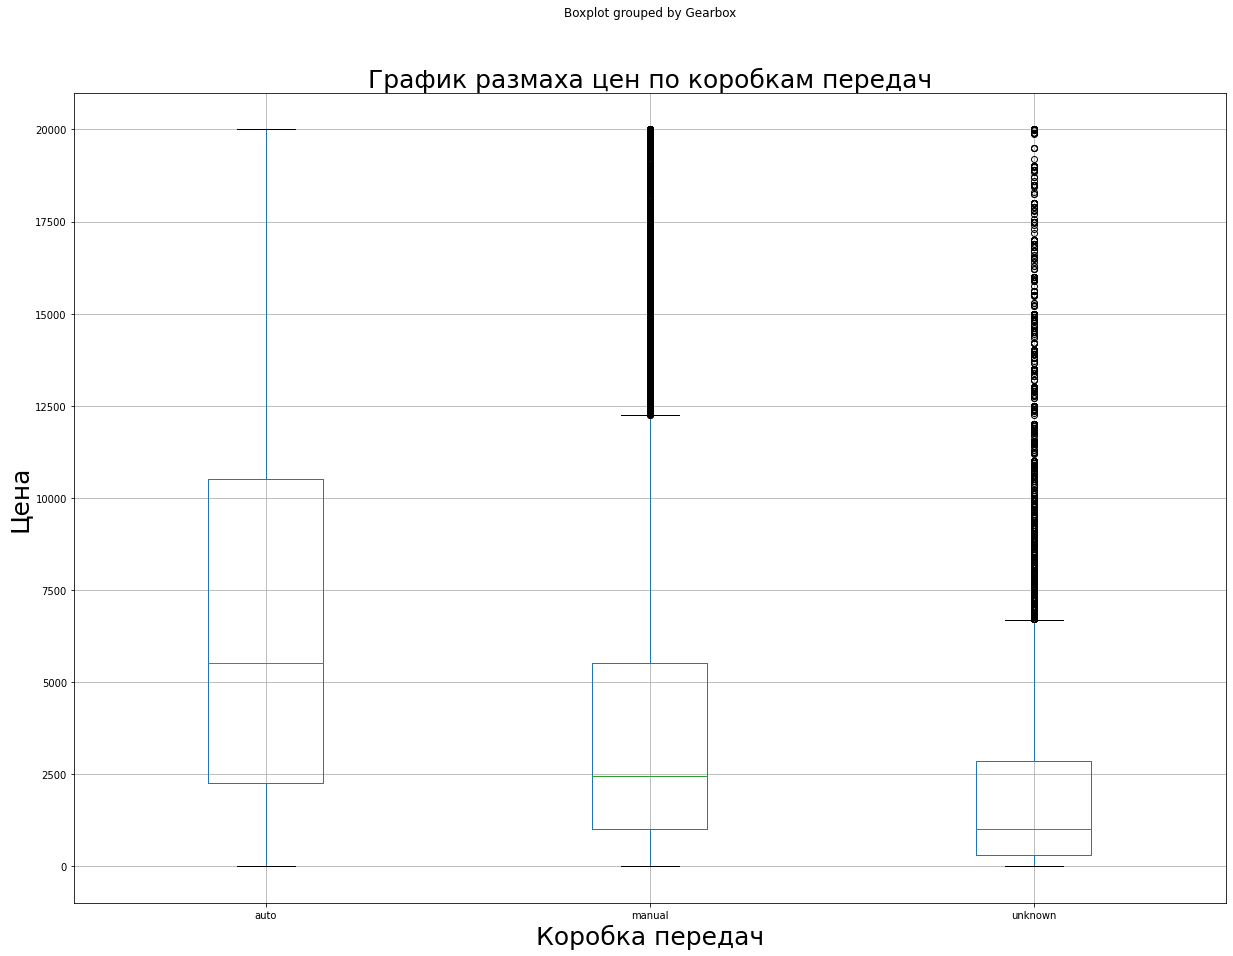

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,65532.0,6816.039691,5383.439555,0.0,2250.0,5500.0,10500.0,20000.0
manual,265958.0,3957.809417,4106.947867,0.0,1000.0,2450.0,5500.0,20000.0
unknown,18730.0,2142.414949,2940.058583,0.0,300.0,1000.0,2850.0,20000.0


In [12]:
# Диаграмма размаха:
auto.boxplot(column='Price', by='Gearbox', figsize=(20, 15))
plt.title('График размаха цен по коробкам передач', fontsize=25)
plt.ylabel('Цена', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Price'].describe()

А вот и очередная проблема: стоимость некоторых машин равна нулю. Понятно, что это явная ошибка. Посмотрим, сколько таких данных.

In [13]:
# Доля "бесплатных" машин:
print('Доля "бесплатных" машин:', len(auto[auto['Price']==0])/len(auto))

Доля "бесплатных" машин: 0.02960710410599052


Незначительная часть, удаляем.

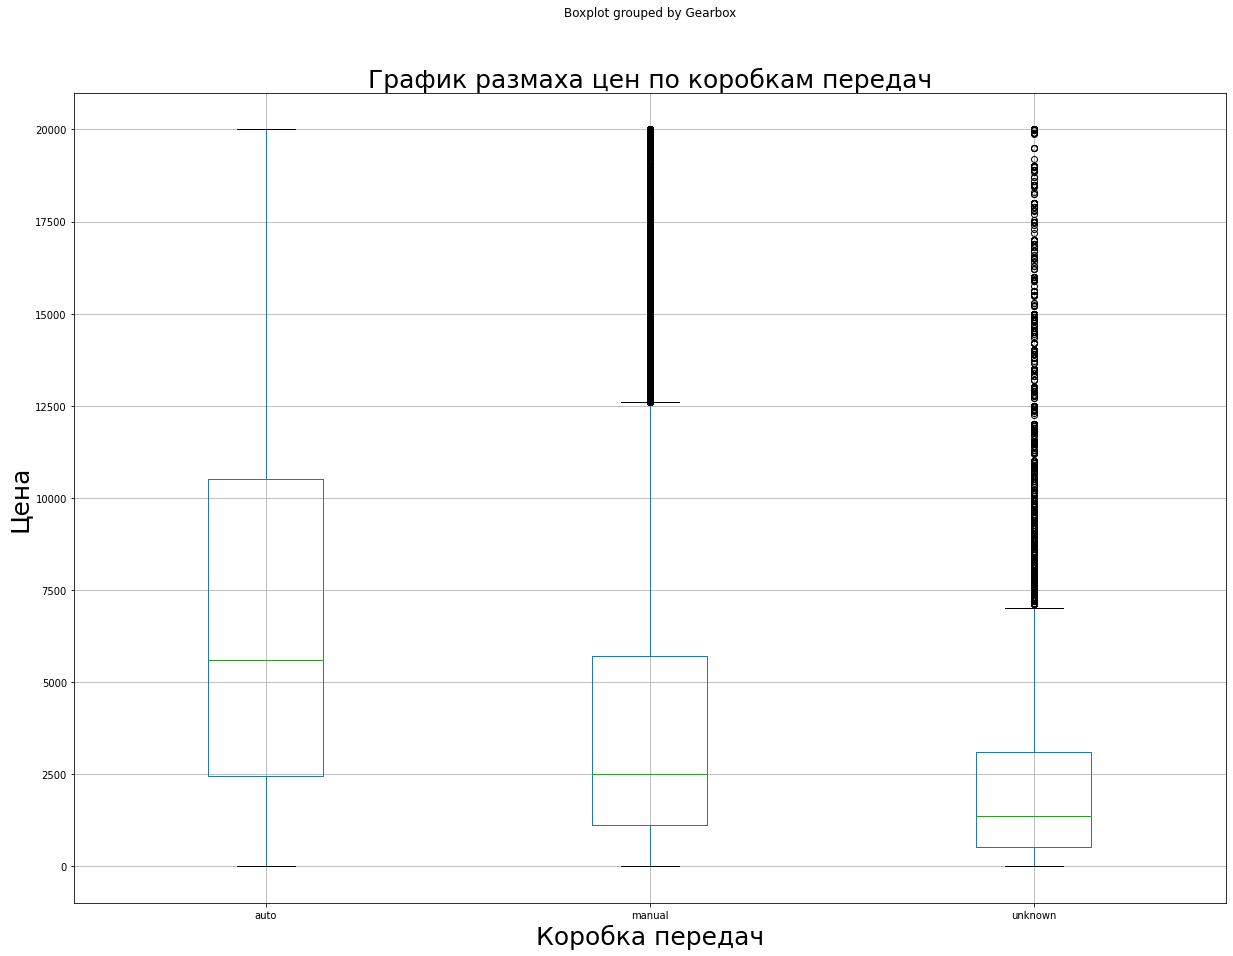

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,64140.0,6963.964967,5346.048895,1.0,2450.0,5600.0,10500.0,20000.0
manual,259203.0,4060.952524,4109.467996,1.0,1100.0,2500.0,5699.0,20000.0
unknown,16508.0,2430.787012,3017.695893,1.0,500.0,1350.0,3100.0,20000.0


In [14]:
# Удаляем аномалии:
auto = auto[auto['Price']!=0]

# Перепроверяем диаграмму:
auto.boxplot(column='Price', by='Gearbox', figsize=(20, 15))
plt.title('График размаха цен по коробкам передач', fontsize=25)
plt.ylabel('Цена', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Price'].describe()

Оказывается, есть ещё и "около бесплатные" предложения. В таком случае введём минимальный порог и вырежем все аномалии. Пусть таким порогом станет цена автомобиля в 1000 у.е.

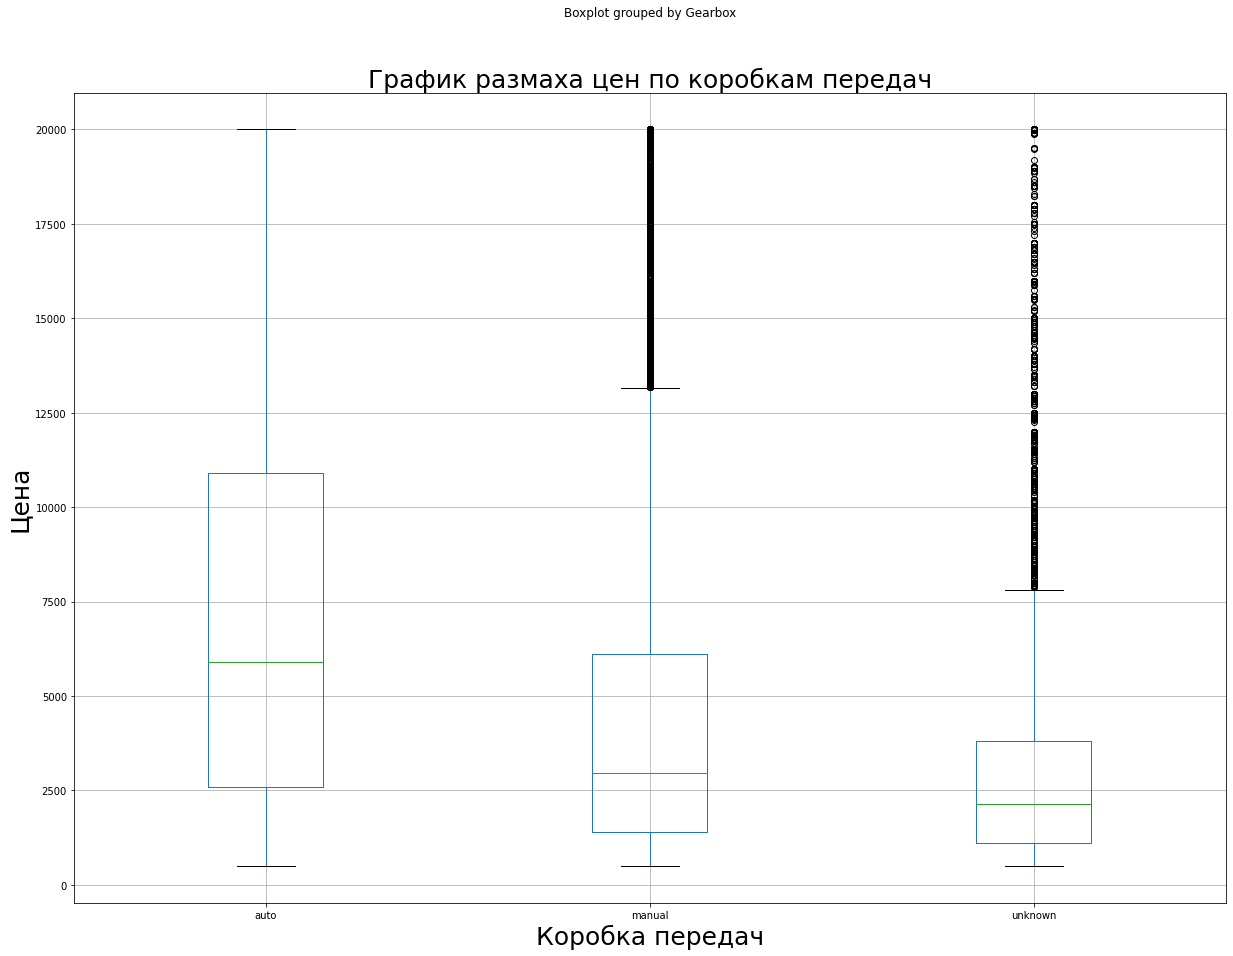

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,62213.0,7169.414399,5297.147703,501.0,2600.0,5900.0,10900.0,20000.0
manual,234755.0,4449.675185,4128.238837,501.0,1400.0,2950.0,6100.0,20000.0
unknown,12281.0,3182.054230,3166.630950,501.0,1100.0,2150.0,3800.0,20000.0


In [15]:
# Удаляем аномалии:
auto = auto[auto['Price'] > 500]

# Перепроверяем диаграмму:
auto.boxplot(column='Price', by='Gearbox', figsize=(20, 15))
plt.title('График размаха цен по коробкам передач', fontsize=25)
plt.ylabel('Цена', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Price'].describe()

Теперь больше похоже на правду. Узнаем, сколько строк мы потеряли.

In [16]:
print("Количество строк после очистки:", len(auto))

Количество строк после очистки: 309249


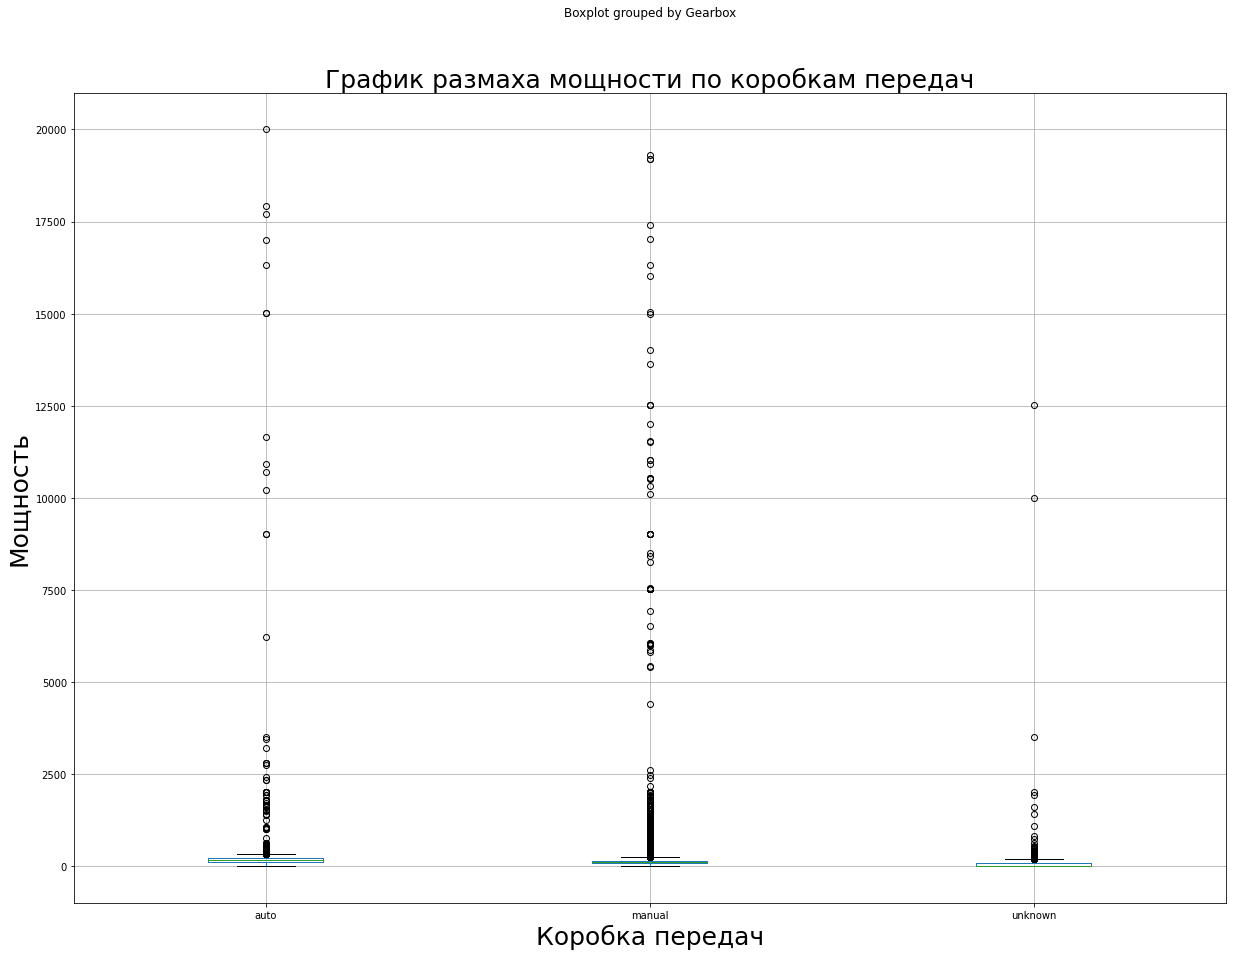

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,62213.0,161.657580,225.216545,0.0,116.0,163.0,200.0,20000.0
manual,234755.0,107.688198,174.884187,0.0,75.0,103.0,136.0,19312.0
unknown,12281.0,44.633255,162.880677,0.0,0.0,0.0,75.0,12510.0


In [17]:
# Диаграмма размаха:
auto.boxplot(column='Power', by='Gearbox', figsize=(20, 15))
plt.title('График размаха мощности по коробкам передач', fontsize=25)
plt.ylabel('Мощность', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Power'].describe()

Кто-то явно не понимал, что указывает. Мощность в 0 лошадиных сил ещё можно как-то попытаться объяснить (например, машина сломана, продаётся по заниженной цене), но вот 20000 это уже за гранью. Удалим явные выбросы, используя порог в 1000 л.с. (у некоторых спорткаров числится именно это значение).

In [18]:
len(auto[(auto['Power']>=0) & (auto['Power']<=50)])

33409

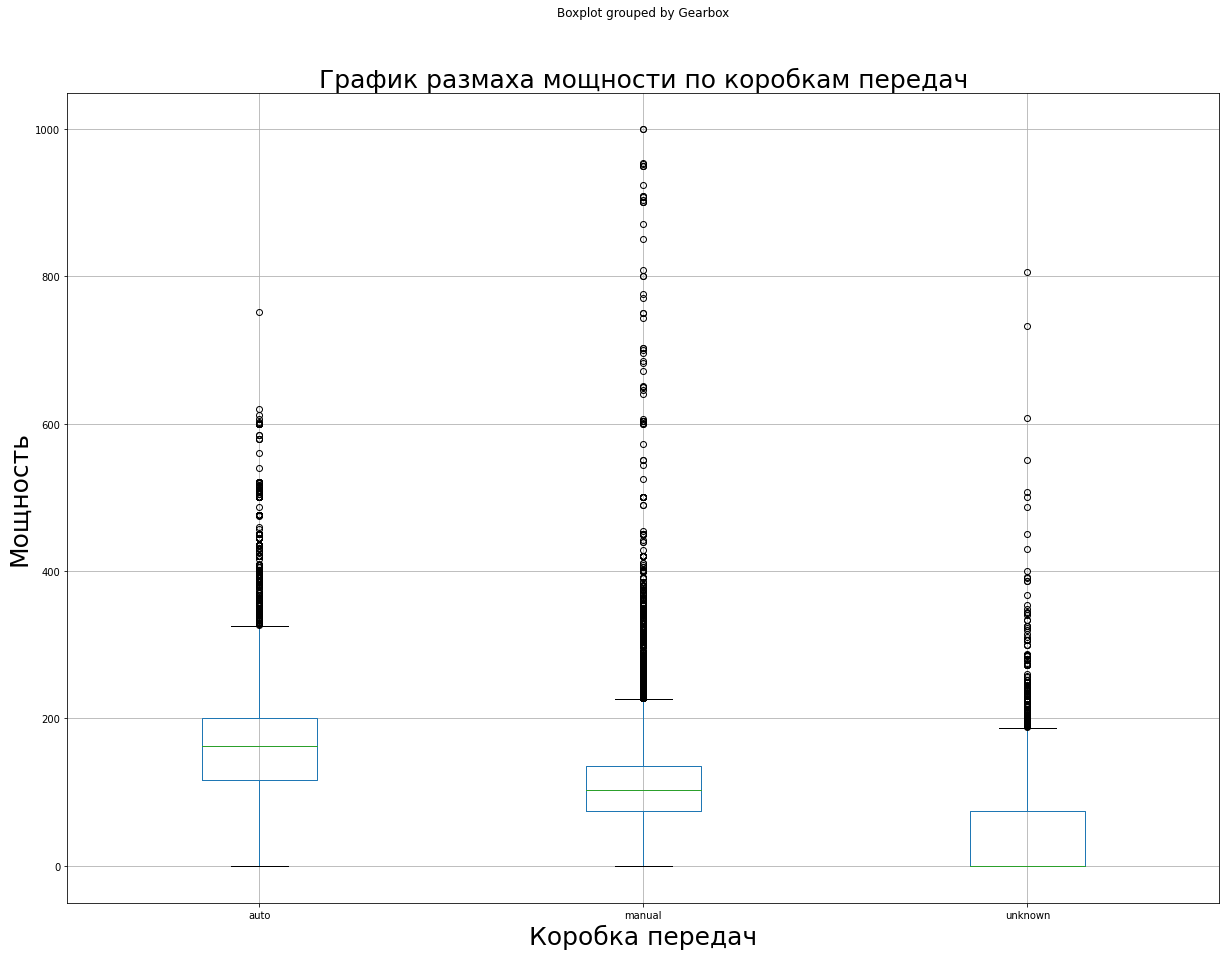

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,62158.0,157.559558,76.156722,0.0,116.0,163.0,200.0,751.0
manual,234574.0,104.583407,50.421759,0.0,75.0,103.0,136.0,999.0
unknown,12273.0,41.889758,61.573175,0.0,0.0,0.0,75.0,805.0


In [19]:
# Удаление явных выбросов:
auto = auto[auto['Power'] < 1000]

# Проверка графика:
auto.boxplot(column='Power', by='Gearbox', figsize=(20, 15))
plt.title('График размаха мощности по коробкам передач', fontsize=25)
plt.ylabel('Мощность', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Power'].describe()

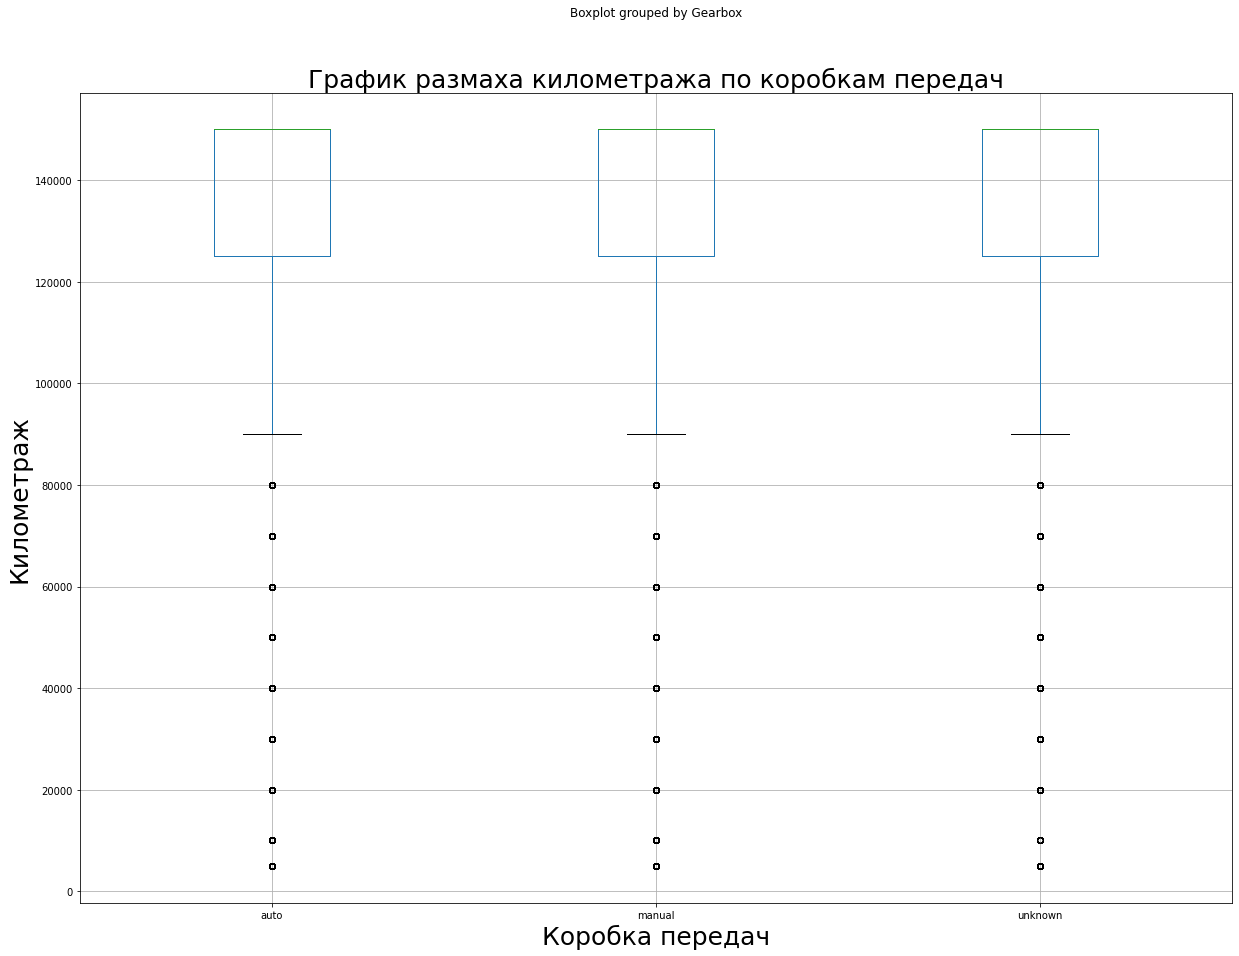

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,62158.0,130048.264101,35602.182628,5000.0,125000.0,150000.0,150000.0,150000.0
manual,234574.0,127799.095381,36972.122069,5000.0,125000.0,150000.0,150000.0,150000.0
unknown,12273.0,128457.182433,40309.228602,5000.0,125000.0,150000.0,150000.0,150000.0


In [20]:
# Диаграмма размаха:
auto.boxplot(column='Kilometer', by='Gearbox', figsize=(20, 15))
plt.title('График размаха километража по коробкам передач', fontsize=25)
plt.ylabel('Километраж', fontsize=25)
plt.xlabel('Коробка передач', fontsize=25)
plt.show()
auto.groupby('Gearbox')['Kilometer'].describe()

Ничего удивительного нет.

### Подготовка к обучению

Некоторые столбцы для обучения модели бесполезны и будут лишь отвлекать на себя внимание. Напишем список таких столбцов и удалим их из таблицы.

In [21]:
# Список столбцов для удаления:
col_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

# Очищаем таблицу:
auto = auto.drop(col_to_drop, axis=1)
display(auto.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,2
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,2


Для красоты обновим индексы строк.

In [22]:
# Обновление индексов строк:
auto = auto.reset_index(drop=True)
display(auto.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,2
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,1
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,2


### Вывод:
Был произведён первичный осмотр данных из предоставленной таблицы. Сразу выявлены следующие проблемы: достаточное количество пропусков и несоответствие некоторых типов данных. Совершены следующие преобразования:

  1) Удалены строки с пропусками;\
  2) Проверена корректность данных;\
  3) Удалены дубликаты;\
  4) Обработаны выбросы.
  
Кроме этого, произведена подготовка данных для обучения моделей - удалены неинформативные столбцы.

## Обучение моделей

Переходим к обучению моделей. Для начала подготовим выборки и зададим необходимые константы.

### Подготовка перед обучением

In [23]:
# Функцию для подсчета RMSE зададим так для дальнейшего удобства:
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

In [24]:
# Формируем списки столбцов для обработки:
ohe_col = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType']
num_col = ['RegistrationYear', 'Power', 'Kilometer', 'Repaired']

In [25]:
# Убираем целевой признак:
feat = auto.drop('Price', axis=1)
target = auto['Price']

# Закодируем качественные признаки:
feat_ohe = pd.get_dummies(feat, columns=ohe_col, drop_first=True)
display(feat_ohe.head())

,RegistrationYear,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown
0,2011,190,125000,2,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2004,163,125000,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2001,75,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2008,69,90000,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1995,102,150000,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
# Задаём константы:
RANDOM_STATE = 1234

# Функция для разбивки на выборки:
def train_valid_test(features, target):
    feat_train, valid_ant_test_feat, target_train, valid_ant_test_target = train_test_split(
        features, target, test_size=0.4, random_state=RANDOM_STATE)

    feat_valid, feat_test, target_valid, target_test = train_test_split(
        valid_ant_test_feat, valid_ant_test_target, test_size=0.5, random_state=RANDOM_STATE)

    del valid_ant_test_feat, valid_ant_test_target
  
    return feat_train, target_train, feat_valid, target_valid, feat_test, target_test

feat_train, target_train, feat_valid, target_valid, feat_test, target_test = train_valid_test(feat_ohe, target)

In [27]:
# Проведем скалирование числовых признаков:
scaler = StandardScaler()

feat_train[num_col] = scaler.fit_transform(feat_train[num_col])
feat_valid[num_col] = scaler.transform(feat_valid[num_col])
feat_test[num_col] = scaler.transform(feat_test[num_col])

display(feat_train.head())

/tmp/ipykernel_93/566992543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_train[num_col] = scaler.fit_transform(feat_train[num_col])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,RegistrationYear,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown
187602,0.961385,-0.220757,-1.037170,-0.528735,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
118194,-1.096375,-1.808103,0.589369,1.107045,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
227936,-1.254664,0.917642,0.589369,2.742825,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7418,-0.463218,0.083885,-1.037170,-0.528735,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
139058,0.011650,-0.188690,0.589369,-0.528735,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Для сравнения моделей будет лучше создать функцию, которая будет записывать все нужные значения. Сделать это можно при помощи класса, один из примеров используем в работе.

In [28]:
# Класс, который будет сохранять время обучения, время предсказания и RMSE:

import time

class ModelCalc:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse
    
# Сохранение результатов в списке:
result = []

Убедимся в работоспособности всего написанного с помощью простой линейной регрессии.

In [29]:
# Обучение модели линейной регрессии:
model_lr = LinearRegression()
model_lr_mc = ModelCalc('Linear regression', model_lr)
model_lr_mc.fit(feat_train, target_train)
model_lr_mc.predict(feat_valid, target_valid)

result.append(model_lr_mc.getResult())
print(result)

[('Linear regression', 16.815768480300903, 0.11186790466308594, 2541.4257973646613)]


Заметим, что мы практически вошли в требуемый диапазон значения метрики.

### Обучение интересующих моделей

По условию задачи необходимо обучить две модели, одна из которых — LightGBM, как минимум одна — не бустинг. Поэтому выбираем LGBMRegressor и CatBoostRegressor.

Обучим обе модели, добавим результаты в табличку с результатами и сравним их.

In [30]:
# Подготовим заново признаки:
feat = auto.drop(columns='Price')
target = auto['Price']

# Разделим выборку на обучающую и тестовую:
feat_train, target_train, feat_valid, target_valid, feat_test, target_test = train_valid_test(feat, target)

In [31]:
# Добавим команду, чтобы избежать ошибок:
pd.options.mode.chained_assignment = None

# Проведем скалирование:
scaler = StandardScaler()
feat_train[num_col] = scaler.fit_transform(feat_train[num_col])
feat_valid[num_col] = scaler.transform(feat_valid[num_col])
feat_test[num_col] = scaler.transform(feat_test[num_col])

display(feat_train.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
187602,small,0.961385,manual,-0.220757,500,-1.037170,petrol,fiat,-0.528735
118194,unknown,-1.096375,unknown,-1.808103,voyager,0.589369,petrol,chrysler,1.107045
227936,sedan,-1.254664,manual,0.917642,a6,0.589369,gasoline,audi,2.742825
7418,convertible,-0.463218,manual,0.083885,z_reihe,-1.037170,petrol,bmw,-0.528735
139058,bus,0.011650,manual,-0.188690,touran,0.589369,gasoline,volkswagen,-0.528735


LightGBM использует свой алгоритм обработки данных, который плохо обрабатывает категориальные признаки. 

У CatBoost такой заморочки нет. Поэтому сначала проведём дополнительную обработку для первой модели, а второй передадим всё, как есть.

In [32]:
# напомним список столбцов с категориальными данными:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Обработка категориальных признаков для GBM:
feat_train_gbm = feat_train.copy()
feat_valid_gbm = feat_valid.copy()
feat_test_gbm = feat_test.copy()

encoder = OrdinalEncoder(handle_unknown='ignore')
feat_train_gbm[cat_col] = encoder.fit_transform(feat_train_gbm[cat_col])
feat_valid_gbm[cat_col] = encoder.transform(feat_valid_gbm[cat_col])
feat_test_gbm[cat_col] = encoder.transform(feat_test_gbm[cat_col])

display(feat_train_gbm.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
187602,5.0,0.961385,1.0,-0.220757,13.0,-1.037170,6.0,9.0,0.0
118194,7.0,-1.096375,2.0,-1.808103,238.0,0.589369,6.0,4.0,1.0
227936,4.0,-1.254664,1.0,0.917642,31.0,0.589369,2.0,1.0,2.0
7418,1.0,-0.463218,1.0,0.083885,247.0,-1.037170,6.0,2.0,0.0
139058,0.0,0.011650,1.0,-0.188690,220.0,0.589369,2.0,38.0,0.0


Ввиду длительного обучения, гиперпараметры меняем в разумных пределах.

In [33]:
# Обучение GBM:
gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE)
gbm_params = {'learning_rate': np.logspace(-5, 0, 5), 'n_estimators': range(40, 60, 20), 'num_leaves': range(30, 40, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=3, scoring='neg_mean_squared_error')
grid_gbm.fit(feat_train_gbm, target_train);

print('Лучшие параметры модели:', grid_gbm.best_params_)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [34]:
# Сделаем предсказания по сборке лучшей модели:
model_gbm = grid_gbm.best_estimator_
model_gbm_mc = ModelCalc('LightGBM', model_gbm)
model_gbm_mc.fit(feat_train_gbm, target_train)
model_gbm_mc.predict(feat_valid_gbm, target_valid)

result.append(model_gbm_mc.getResult())
print(result)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[('Linear regression', 16.815768480300903, 0.11186790466308594, 2541.4257973646613), ('LightGBM', 2.206404447555542, 0.19756317138671875, 1782.9348586054164)]


Чудно, вместо 2541 получили значение метрики RMSE в 1782. Осталось проверить результаты у CatBoost.

In [35]:
# Модель CatBoost:
cbr = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=ohe_col, random_seed=RANDOM_STATE)
cbr_params = {'learning_rate': np.logspace(-5, 0, 5),'iterations': range(20, 60, 20),'depth': range(5, 10, 2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(feat_train, target_train);

print('Лучшие параметры модели:', grid_cbr.best_params_)

Лучшие параметры модели: {'depth': 9, 'iterations': 40, 'learning_rate': 1.0}


In [36]:
# Посмотрим, что получилось в итоге
model_cbr = grid_cbr.best_estimator_
model_cbr_mc = ModelCalc('CatBoost', model_cbr)
model_cbr_mc.fit(feat_train, target_train)
model_cbr_mc.predict(feat_valid, target_valid)

result.append(model_cbr_mc.getResult())
print(result)

[('Linear regression', 16.815768480300903, 0.11186790466308594, 2541.4257973646613), ('LightGBM', 2.206404447555542, 0.19756317138671875, 1782.9348586054164), ('CatBoost', 4.312258720397949, 0.06806159019470215, 1722.1186368426695)]


Мало того, что метрика лучше, так ещё и скорость предсказания в разы быстрее.

### Вывод:
Были подготовлены необходимые функции для подсчёта метрики RMSE и дробления исходного датафрейма на выборки.

В результате работы обучены 3 модели - 1 обычная и 2 с бустом: Linear Regression, LightGBM и CatBoost. По предварительной оценке можно сказать, что модели буста справляются с задачей предсказания целевого признака намного лучше, чем обычные.

Результаты предсказаний всех моделей занесены в список result, что позволит оперативно ознакомиться со всеми данными и сделать необходимые выводы.

## Анализ моделей

Теперь осталось только совместить полученные результаты и сделать необходимые выводы. Для удобства напишем функцию вывода данных из сформированного списка.

In [37]:
# Функция для красивого вывода результатов:
def nice_print(result):
    print('|{: >18}|{: >15}|{: >20}|{: >15}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for res in result:
        print('|{: >18}|{: >15f}|{: >20f}|{: >15f}|'.format(res[0], res[1], res[2], res[3]))
        
nice_print(result)

|            Модель| Время обучения|  Время предсказания|           RMSE|
| Linear regression|      16.815768|            0.111868|    2541.425797|
|          LightGBM|       2.206404|            0.197563|    1782.934859|
|          CatBoost|       4.312259|            0.068062|    1722.118637|


Совершим предсказания лучшей модели на тестовой выборке.

In [38]:
# Предсказания лучшей модели:
best_model = model_cbr_mc
best_model.predict(feat_test, target_test)

char_of_best = []
char_of_best.append(best_model.getResult())
nice_print(char_of_best)

|            Модель| Время обучения|  Время предсказания|           RMSE|
|          CatBoost|       4.312259|            0.069701|    1697.827294|


### Вывод:
По последнему выводу наглядно представлен результат проделанной работы.
  - В условие RMSE < 2500 уложились все модели (простим линейной регрессии небольшое несоответствие), однако модели с бустом справили с задачей гораздо лучше (LightGBM с 1782 и CatBoost с 1722);
  - Время предсказания у LightGBM оказалось наибольшим, линейная модель быстрее на треть, а вот CatBoost справилась в три раза быстрее конкурентов;
  - Минимальное время обучения (3 секунды) у LightGBM (с ограниченной вариацией гиперпараметров), 4 секунд у CatBoost, гораздо дольше обучалась линейная модель.
  
Наилучшим вариантом для заказчика за счёт наименьшего времени предсказывания и максимальной метрики является модель CatBoost со следующими параметрами: depth = 9, iterations = 40, learning_rate = 1.0. Метрика RMSE на тестовой выборке оказалась равна 1697, что полностью удовлетворяет условию задачи.

## Итоговый вывод:
Получена таблица с данными о сервисе продажи автомобилей. Необходимо подобрать заказчику оптимальную модель МО, которая будет удовлетворять обозначенным условиям.

Был произведён первичный осмотр данных из предоставленной таблицы. Сразу выявлены следующие проблемы: достаточное количество пропусков и несоответствие некоторых типов данных. Совершены следующие преобразования:

  1) Удалены строки с пропусками;\
  2) Проверена корректность данных;\
  3) Удалены дубликаты;\
  4) Обработаны выбросы.
  
Кроме этого, произведена подготовка данных для обучения моделей - удалены неинформативные столбцы.

Были подготовлены необходимые функции для подсчёта метрики RMSE и дробления исходного датафрейма на выборки.

В результате работы обучены 3 модели - 1 обычная и 2 с бустом: Linear Regression, LightGBM и CatBoost. По предварительной оценке можно сказать, что модели буста справляются с задачей предсказания целевого признака намного лучше, чем обычные.

Результаты предсказаний всех моделей занесены в список result, что позволит оперативно ознакомиться со всеми данными и сделать необходимые выводы.

По последнему выводу наглядно представлен результат проделанной работы.
  - В условие RMSE < 2500 уложились все модели (простим линейной регрессии небольшое несоответствие), однако модели с бустом справили с задачей гораздо лучше (LightGBM с 1782 и CatBoost с 1722);
  - Время предсказания у LightGBM оказалось наибольшим, линейная модель быстрее на треть, а вот CatBoost справилась в три раза быстрее конкурентов;
  - Минимальное время обучения (3 секунды) у LightGBM (с ограниченной вариацией гиперпараметров), 4 секунд у CatBoost, гораздо дольше обучалась линейная модель.
  
Наилучшим вариантом для заказчика за счёт наименьшего времени предсказывания и максимальной метрики является модель CatBoost со следующими параметрами: depth = 9, iterations = 40, learning_rate = 1.0. Метрика RMSE на тестовой выборке оказалась равна 1697, что полностью удовлетворяет условию задачи.

Работа проделана в полном объёме, все цели достигнуты, результат удовлетворительный.

## Рекомендации для бизнеса:
В исходной таблице было много недочётов, необходимо обратить внимание на заполнение данных при выставлении машин на продажу. Практически треть данных пришлось удалить, но благодаря большому общему объёму исследование стало возможным.

Поставленная задача выполнена, дополнительные исследования не требуются.